## Session 4: Embedding - Q&A

### Intro

Denne notebooken fokuserer på å jobbe med tekstdata on-prem, uten eksterne API-kall. Her er stegene:

- **Splitte et dokument til paragrafer:** Del et lengre dokument inn i mindre paragrafer for enklere håndtering.
- **Konvertere til embeddings:** Bruk teknikker som BERT eller FastText for å konvertere paragrafene til numeriske vektorer (embeddings).
- **Flytte til en vektor-database:** Lagre embeddings i en database som FAISS eller Annoy, som tillater raskt oppslag og sammenligning.
- **Finn dokumenter basert på spørsmålet:** Gjennomfør en søkeoperasjon i databasen for å finne de mest relevante paragrafene eller dokumentene basert på spørsmålets embedding.
- **Finn svaret i dokumentet:**  Bruk Language Model for å identifisere det mest relevante svaret i valgte paragrafer basert på inngående spørsmål.

Vi benytter denne metoden for å håndtere konfidensiell eller intern data uten å måtte dele den med tredjeparter.

Selv om OpenAI sin modell er state-of-the-art, er det viktig å merke seg at det er en "black-box" i forhold til databehandling.

Til slutt vil vi demonstrere hvordan alt dette kan implementeres i et UI ved bruk av Chainlit, inkludert henvisninger til relevante kilder.


Først trenger vi å installere noen bibloteker.
For sentence embedding skal vi bruke [SentenceTransformers ](https://www.sbert.net/) som er gratis.

Vi kan bruke også OpenAI sin løsning [text-embedding-ada-002](https://platform.openai.com/docs/guides/embeddings/what-are-embeddings) som er bedre og mye større embeddings (nsize=`1535`), men det koster penger og er et ekstern API. For å lage embeddings for hele Harry Potter bokserien, koster det bare ~1$ for å prossesere 3400 sider med tekst 😅

In [1]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 12.4 MB/s eta 0:00:0000:0100:01
  Obtaining dependency information for numpy~=1.24.1 from https://files.pythonhosted.org/packages/c0/bc/77635c657a3668cf652806210b8662e1aff84b818a55ba88257abf6637a8/numpy-1.24.4-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for rich~=13.6.0 from https://files.pythonhosted.org/packages/be/2a/4e62ff633612f746f88618852a626bbe24226eba5e7ac90e91dcfd6a414e/rich-13.6.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 11.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.8/239.8 kB 11.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.0
    Uninstalling numpy-1.26.0:
      Successfully uninstalled numpy-1.26.0
  Attempting uninstall: rich
    Found existing installation: rich 13.4.2
    Uninstalling rich-13.4.2:
      Successfully uninstalled rich-13.4.2
  Attempting unins

In [22]:
# Vi lever litt farlig nå og bare ignorer all advarsel flaggene fra bibloteker 😈
import warnings
warnings.filterwarnings("ignore")

# La oss bruke rich for mer formatteringer og emojis 🤓
from rich import print


Vi starter med å lage en embedding og bruker [multi-qa-MiniLM-L6-cos-v1](https://huggingface.co/sentence-transformers/multi-qa-MiniLM-L6-cos-v1) modellen til å lage embeddings.

In [3]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

org_text = 'How big is London'
embedding_01 = model.encode(org_text)
embedding_01

array([ 2.13617951e-01,  3.64456535e-03,  6.68863431e-02, -8.09083432e-02,
       -6.88738525e-02, -2.95351166e-02,  5.69824129e-02,  4.15854380e-02,
       -8.66393521e-02, -1.54837745e-03, -1.66739873e-03, -6.20796233e-02,
       -2.15016156e-02, -2.83825044e-02, -3.12040895e-02, -3.62611115e-02,
       -1.58209819e-03, -9.05911103e-02, -8.14452767e-02, -1.81068089e-02,
        1.34018764e-01, -4.30189930e-02,  5.22156283e-02,  6.75390512e-02,
       -7.64247403e-02,  2.46958286e-02,  1.51146343e-02,  9.71993059e-02,
        1.88188767e-03,  4.02951911e-02, -8.18578247e-03, -4.77733165e-02,
       -2.18554437e-02, -3.84991476e-03,  3.99325341e-02,  3.86554585e-03,
        1.72126293e-02, -3.02566728e-03,  3.86403129e-02, -4.21452373e-02,
        4.41678949e-02, -4.23261262e-02,  6.50313348e-02, -1.42178694e-02,
        2.11600978e-02,  5.53219989e-02,  2.70084124e-02,  5.25653437e-02,
       -5.19815879e-03, -9.78330597e-02,  8.21333826e-02,  3.92637029e-02,
        1.02433357e-02, -

### Oppgave: 
Hvor stor er embeddings vektoren?

La oss lage flere setninger, og konvertere de til embeddings

In [4]:
text = ['London has 9,787,426 inhabitants at the 2011 census',
        'London is known for its finacial district',
        'The capital of United Kingdom is',
        'The largest city in England',
        'BREXIT',
        'The royal corgis lived in Westminster',
                                  ]

set_of_embedding = model.encode(text)
set_of_embedding

array([[ 0.12549888, -0.01423618,  0.06823369, ...,  0.04764377,
        -0.07658357,  0.01014997],
       [ 0.20452395, -0.01486546,  0.03295972, ...,  0.01887436,
        -0.07937784,  0.04315902],
       [ 0.17675205, -0.0752627 , -0.01795857, ...,  0.01271262,
        -0.0066539 ,  0.02282776],
       [ 0.17783879, -0.03708382, -0.00985559, ...,  0.01986176,
         0.0187079 ,  0.09004077],
       [ 0.05394064,  0.02046371,  0.05930651, ...,  0.01930566,
         0.00483003,  0.09824789],
       [ 0.08769707,  0.00034237, -0.03004534, ...,  0.01354876,
        -0.02880585, -0.04013046]], dtype=float32)

Nå har vi et sett med embeddings, la oss sammenligne de med orginal teksten vi hadde tidligere ("How big is London?")
Vi bruker en av de vanligste metriker,  [Cosine Similarity](https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity)

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim = cosine_similarity(embedding_01.reshape(1, -1), set_of_embedding)[0]

print(f"Comparision with the '{org_text}':")
for sim, txt in zip(cos_sim, text):
    print(f" {sim:0.2f} ->  {txt}" )

Comparision with the 'How big is London':

0.55 ->  London has 9,787,426 inhabitants at the 2011 census

0.63 ->  London is known for its finacial district

0.45 ->  The capital of United Kingdom is

0.61 ->  The largest city in England

0.31 ->  BREXIT

0.30 ->  The royal corgis lived in Westminster

### Oppgave

Basert på `set_of_embedding`, ta gjennomsnitt av vektorene slik at det blir en *global average vector*  og sjekk "similarity" igjen.

In [6]:
# TODO: Basert på set_of_embedding, ta gjennomsnitt av vektorene slik at det blir en  og sjekk "similarity" igjen


## Et eksempel:
##print("Similarity:", cosine_similarity(embedding_01.reshape(1, -1), set_of_embedding.mean(axis=0).reshape(1, -1)))

Vi kan bruke cosine-similaritet for å måle vinkelavstanden mellom vektorer, noe som hjelper oss å finne vektorer som er nærmest eller lengst fra hverandre i et datasett.

En annen metode er å bruke embeddings, som er vektorrepresentasjoner av objekter, for å finne outliers. Embeddings kan fange opp mer komplekse mønstre, noe som kan være nyttig for å identifisere unike eller avvikende elementer i dataene.

### Oppgave
1. Tenk på hvilken bruksområder dette er nyttig i.
2. I neste kode-blokk, lekk inn en urelatert setning som ikkje er i nærheten til de andre datapunktene for å skape en outlier i datasettet.
3. Sjekk ut hvordan cosine similarity til den setningen du la inn.

In [7]:

# TODO: Legg inn en random setning som ikkje er i nærheten til de andre datapunktene og append det til det eksisterende datasettet

data = ['London has 9,787,426 inhabitants at the 2011 census',
        'London is known for its finacial district',
        'Oslo is the capital in Norway',
        'Haugesund is located on the west coast of Norway',
        'Norway has the longest coastline in the world.',
        'Tromsø is often called the northern Paris',
        'Paris is the captial of France',
        ]

input_text = """I love working with data science"""


# TODO: Append til datasettet

## data.append(input_text)




Vi skal nå bruke en metode for å identifisere outliers, den heter IsolationForest.

**IsolationForest** er en algoritme for outlier-deteksjon. Den deler opp rommet hvor dataene befinner seg ved å lage *trær*, og isolerer hver datapunkt ved å telle antall delinger nødvendig for å isolere det. Outliers blir vanligvis isolert raskere, og dermed kan de identifiseres.

In [69]:

from sklearn.ensemble import IsolationForest
sets_of_embedding = model.encode(data)

clf = IsolationForest(n_estimators=100,
                     contamination='auto', 
                     random_state=42,
                     ) 
preds = clf.fit_predict(sets_of_embedding)

preds = ["❌"  if p == -1  else "✅"  for p in preds ]
print(f"{len(preds)} predictions. Set of possible values: {set(preds)}")

for p, t in zip(preds, data):
    #out_txt = "❌" if p == -1 else "✅"
    
    print(f"{p} {t}")

## TODO: Test forskjellige parametere! 🤓

8 predictions. Set of possible values: {'❌', '✅'}

✅ London has 9,787,426 inhabitants at the 2011 census

✅ London is known for its finacial district

✅ Oslo is the capital in Norway

✅ Haugesund is located on the west coast of Norway

✅ Norway has the longest coastline in the world.

✅ Tromsø is often called the northern Paris

✅ Paris is the captial of France

❌ I love working with data science

### Vektor database

Vi skal nå bruke en PostgreSQL database sammen med pgVector for å lagre en del embeddings.
Vi benytter L2-avstand '<->' for oppslag; en annen tilnærming er å beregne vinkelen mellom vektorer med '<=>'.

For mer info sjekk [dokumentasjonen for pgVector](https://github.com/pgvector/pgvector)

Basert på databasens resultater, får vi riktig kontekst for vår spørsmål. Men målet er å gi et presist svar, ikke bare en liknende setning.

Her kommer LLM fra sesjon 3 inn, og vi bruker [flan-t5-base](https://huggingface.co/google/flan-t5-base) for å finne det eksakte svaret i den valgte konteksten. 🔥


In [1]:
import numpy as np
import psycopg2
import pandas as pd

from pgvector.psycopg2 import register_vector

# Sett opp tilgang til PostgreSQL database
conn = psycopg2.connect(user="svalbard", 
                       password="!", 
                       host="svalbard.postgres.database.azure.com", 
                       port=5432, 
                       database="postgres")

register_vector(conn)
cur = conn.cursor()

In [8]:
# TODO: Lag en ny tabell, husk at du deler databasen med resten av gjengen så finn på et unikt navn!
# Eks på SQL query for en tabell:

cur.execute("CREATE TABLE YOUR_TABLE_HERE (id bigserial PRIMARY KEY, content text, embedding vector(384));")
conn.commit()

# Lager en tabell "YOUR_TABLE_HERE" med tre kolonner: en unik ID (id), tekstinnhold (content), og en 384-dimensjonal vektor (embedding). id er primærnøkkel.

In [13]:
# Vi sjekker dataen igjen, i neste notebook cell, skal vi ingeste denne i databasen sammen med embeddingen!
print(data)

# TODO: Hvis du vil kan du appende mer data i listen 🤓

[
    'London has 9,787,426 inhabitants at the 2011 census',
    'London is known for its finacial district',
    'Oslo is the capital in Norway',
    'Haugesund is located on the west coast of Norway',
    'Norway has the longest coastline in the world.',
    'Tromsø is often called the northern Paris',
    'Paris is the captial of France'
]

In [10]:

# TODO: Husk å endre table navn
for idx, sentence in enumerate(data):
        print(idx, sentence)
        emb = model.encode(sentence)
        ## cur.execute('INSERT INTO YOUR_TABLE_HERE (content, embedding) VALUES (%s, %s)', (sentence, emb,))
        ## conn.commit()


0 London has 9,787,426 inhabitants at the 2011 census

1 London is known for its finacial district

2 Oslo is the capital in Norway

3 Haugesund is located on the west coast of Norway

4 Norway has the longest coastline in the world.

5 Tromsø is often called the northern Paris

6 Paris is the captial of France

In [ ]:
## TODO: Gjør en SQL query mot tabellen din

#sql_query = "SELECT * FROM XXXX"
#cur.execute(sql_query)
rows = cur.fetchall()




In [ ]:
# TIPS: Hvis dere er glad i pandas, så kan dere bruke pd.read_sql()

# EKSEMPEL:  pd.read_sql("SELECT * FROM YOUR_TABLE_HERE LIMIT 10", conn)

Nå skal vi utnytte GPT-modellen fra forrige sesjon i kombinasjon med embeddings for å besvare spørsmål mer effektivt. Ved å bruke embeddings kan vi lage en "query" som representerer spørsmålet, og så søke i et datasett av dokumenter for å finne de mest relevante svarene. Dette gir oss en mer målrettet og nøyaktig måte å hente informasjon på.


### Oppgave:
1. Lag en spørring feks. 'Hva er hovedstaden i Norge' og se hvis resultatet matcher det du spør om og lag en embedding av det. **NB**: bør være innen emne som allerede ligger inn vektordatabasen.
2. Konverter spørsmålet til embedding.
3. Sjekk embeddingen imot tabellen i databasen 
4. Bruk f. eks. de to mest like setningene til å lage *contexten* som blir sendt inn til LLM modellen sammen med spørsmåølet.
   F. eks på en promt med f-string:
   ```
   prompt = f"""
   Answer the question using the content:
   Question: {query}
   Content: {answer}
   """
   ``` 
5. Tokenzise promt'en og send det til modellen og få svaret.

In [12]:

# TODO: Lag en spørring feks. 'Hva er hovedstaden i Norge' og se hvis resultatet matcher det du spør om og lag en embedding av det


import torch
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer
from transformers import GenerationConfig

# Vi bruker 

# Last inn modellen
model_name='google/flan-t5-base'
original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model2 = AutoModelForSeq2SeqLM.from_pretrained(model_name)


# TODO: Lag et spørsmål (bør være innen emne som allerede ligger inn vektordatabasen )
#query = "Whats the capital of Norway?"

query = "Can you mention a city on the west coast?"
emb = model.encode(query)

# TODO: Sett inn embeddings for XXX
df = pd.read_sql(f"SELECT id, content, embedding <-> '{list(emb)}' AS distance FROM test01;", conn)
df

# TODO: Lag en string med de mest aktuelle Get the most similar sentence from the dataframe, note the distance is L2

answer = list(df.sort_values('distance').iloc[0:2].content)
answer = '. '.join(answer)
answer

dialogue = "Hello"
prompt = f"""
Answer the question using the content:
Question: {query}
Content: {answer}
"""

inputs = tokenizer(prompt, return_tensors='pt')

output = tokenizer.decode(
    model2.generate(
        inputs["input_ids"], 
        max_new_tokens=100,
        temperature=0,
        top_k=3,
    )[0], 
    skip_special_tokens=True
)

print(f"Question: {query}")
print(10*"-")
print(f"Content: {answer}")
print(10*"-")
print(f'Answer: {output.capitalize()}')



Question: Can you mention a city on the west coast?

----------

Content: Norway has the longest coastline in the world.. Haugesund is located on the west coast of Norway

----------

Answer: Haugesund

# Ekstra

Her fokuserer vi på "clustering" og klassifikasjon av tekst ved hjelp av embeddings. Vi bruker Principal Component Analysis (PCA) for å redusere dimensjonene av disse embeddingsene og projisere dem inn i et 2D-rom. Dette gjør det lettere å visualisere grupperinger og mønstre i dataene, som igjen kan hjelpe oss med å klassifisere tekster mer effektivt.

## Oppgave
Legg til en ny setning i datasettet, konverter til embedding og bruk PCA for å se dens plass i 2D-rommet. 

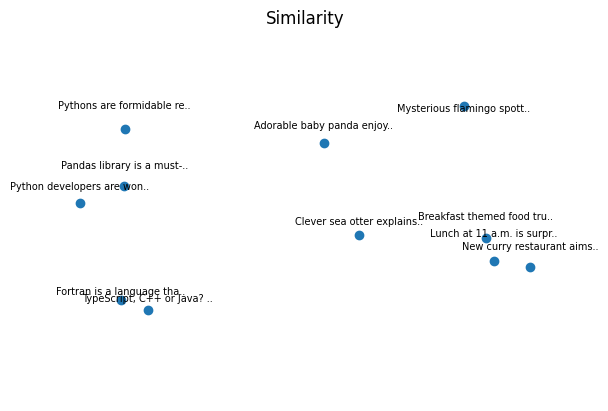

In [243]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


in_1 = "Mysterious flamingo spotted at the poolside."
in_2 = "Clever sea otter explains Kafka pipeline with illustrations."
in_3 = "Adorable baby panda enjoys a boat adventure."
in_4 = "Breakfast themed food truck beloved by all!"
in_5 = "New curry restaurant aims to please!"
in_6 = "Python developers are wonderful people."
in_7 = "TypeScript, C++ or Java? All are great!" 
in_8 = "Lunch at 11 a.m. is surprisingly early."
in_9 = "Pandas library is a must-have for data analysis!"
ln_10 = "Pythons are formidable reptiles known for their sharp teeth and dangerous bites."
ln_11 = "Fortran is a language that is specialized for high-performance computing."

input_text_lst_news = [in_1, in_2, in_3, in_4, in_5, in_6, in_7, in_8, in_9, ln_10, ln_11]

embedding_lst_news = [model.encode(txt) for txt in input_text_lst_news]
embedding_lst_news_array = np.array(embedding_lst_news) 
embedding_lst_news_array.shape[0]


# Perform PCA for 2D visualization
PCA_model = PCA(n_components = 2, random_state=42)
PCA_model.fit(embedding_lst_news_array)
new_values = PCA_model.transform(embedding_lst_news_array)


plt.scatter(new_values[:, 0], new_values[:, 1])

for i, label in enumerate(input_text_lst_news):
    offset_y = np.random.randint(-30, 30)/100.+ 1
    plt.annotate(label[:25] + "..", (new_values[i, 0], new_values[i, 1]*offset_y), 
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=7)

# Remove borders and ticks
plt.title("Similarity")
plt.xticks([])
plt.yticks([])
plt.ylim([-1, 1])
plt.box(False)




Til slutt vil vi trene en enkel tekstklassifikator ved å bruke embeddings.

**Advarsel:** Vi bruker en liten LLM-modell for dette. Resultatene vil være mye bedre med en state-of-the-art modell.

Datasettet kommer fra [Kaggle Ecommerce Text Classification](https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification).
Det er allerede prosessert til embddings og ligger i en tabell i databasen.

Den innholder:
- Number of Instances: 50425
- Number of classes: 4

hvor de fire kategoriene er: `Electronics`, `Household`, `Books` and `Clothing & Accessories`


In [15]:
# Last inn datasett som skal brukes til tekst klassifisering

## DETTE ER RÅ-DATA, hvis dere er nysgjerrig på datasettet
### https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification
###df = pd.read_csv('fun_facts.csv', sep=";")


# Dataen er allerede pre-prossesert og lagt inn i databasen
df = pd.read_sql(""" SELECT label, embedding FROM ecommerce  """, conn)

x = np.vstack(df.embedding.values)
y = df.label.values

# Vis 10 random embeddings
df.sample(10, random_state=42)


,label,embedding
8194,Household,"[-0.013984185, 0.018803848, -0.043725364, -0.0..."
34140,Clothing & Accessories,"[-0.04512606, 0.0746322, 0.042232543, 0.117384..."
38517,Clothing & Accessories,"[-0.046745628, 0.11667362, 0.05726375, 0.04327..."
48606,Electronics,"[0.035663668, 0.03052294, -0.021249464, -0.008..."
35605,Clothing & Accessories,"[-0.0013997748, 0.11280111, 0.054788843, 0.125..."
29229,Books,"[-0.03345464, -0.04719906, -0.007830159, 0.025..."
4413,Household,"[-0.009477889, 0.08370634, -0.006698783, -0.01..."
24674,Books,"[-0.06542809, -0.053665332, -0.025912888, 0.03..."
10783,Household,"[-0.045234445, 0.01401524, -0.04655242, 0.1012..."
21421,Books,"[-0.053666487, -0.026723858, -0.0033828584, 0...."


La oss først pm det er noen variasjonener i datasettet med bruk av PCA til reduserer dimensjonaliteten.
 

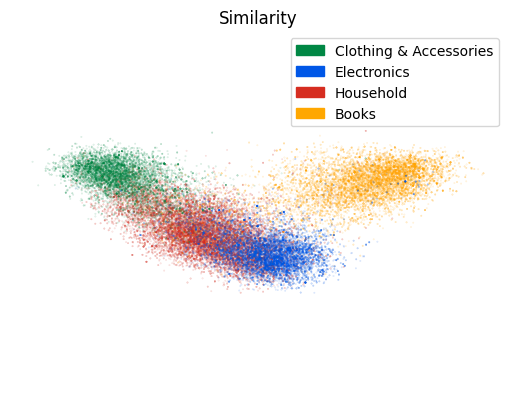

In [16]:

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA

# Perform PCA for 2D visualization
PCA_model = PCA(n_components = 2, random_state=42)
PCA_model.fit(x)
new_values = PCA_model.transform(x)

colors_setting = {
          "Clothing & Accessories": "#008744", 
          "Electronics": "#0057e7",
          "Household": "#d62d20",
          "Books": "#ffa700"
          }

c = [colors_setting[j] for j in y]


patches = [mpatches.Patch(color=c, label=l) for l, c in colors_setting.items()]

plt.scatter(new_values[:, 0], new_values[:, 1], c=c, alpha=0.2, s=0.1)
plt.legend(handles=patches, loc='upper right')

for i, label in enumerate(x):
    offset_y = np.random.randint(-30, 30)/100.+ 1
    #plt.annotate(label[:20] + "..", (new_values[i, 0], new_values[i, 1]*offset_y), 
    #             textcoords="offset points", xytext=(0,10), ha='center', fontsize=7)

# Remove borders and ticks
plt.title("Similarity")
plt.xticks([])
plt.yticks([])
plt.ylim([-1, 1])
plt.box(False)

Resultatet viser en separasjon mellom de ulike klassene, så nå kan vi bygge en klassifiseringsmodell.

**IF-TODO:** I dette eksemplet bruker vi RandomForest, som er robust i de fleste tilfeller. Men prøv gjerne andre modeller for å se hvordan de presterer.

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state=42)

clf = RandomForestClassifier(n_estimators=100, 
                             max_samples=0.2, 
                             max_depth=20,
                             random_state=42, 
                             n_jobs=-1, 
                             class_weight='balanced')

clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred) 
print(f"Accuracy: {accuracy:0.2f}")


Accuracy: 0.95

In [35]:
# Bruker en fra test datasettet, velg en random index
idx = 52
question_embedding = x_test[idx]
# get the embedding of this question and predict its category
pred = clf.predict(question_embedding.reshape(1, -1))
txt = pd.read_sql(f"SELECT * FROM ecommerce ORDER BY embedding <=> '{list(question_embedding)}' LIMIT 1", conn).content[0]

print(50*"-")
print(f"Input: {txt[:55]}..")
print(f"Prediction: {pred[0]}")
print(f"Correct: {y_test[idx]}")
print(50*"-")


## MANUALLY
txt = "We can use this for cleaning"
# get the embedding of this question and predict its category
question_embedding = model.encode([txt])
pred = clf.predict(question_embedding)

print(f"Input: {txt[:55]}") 
print(f"Prediction: {pred[0]}")

--------------------------------------------------

Input: ACE Stainless Steel Steak Knife (Colors May Vary) Ace S..

Prediction: Household

Correct: Household

--------------------------------------------------

Input: We can use this for cleaning

Prediction: Household

# Ekstra
Nå har du fått en forståelse av hvordan du kan bygge en tabell med ekstern data. Neste steg er å "ingeste" et datasett eller en bok inn i denne tabellen.

1. Del opp teksten i "chunks" for å isolere innhold og fange opp kontekst ved spørringer. Valget av "chunk"-størrelse kan være empirisk og avhenge av datatypen. Du kan også bruke en "sliding window" med overlappende tekst.
2. Lag en ny tabell (sørg for et unikt navn på tabellen).
3. Ingest dataen inn i tabellen.
4. Utfør en spørring for å hente ut relevant informasjon.

**Tips:** Å splitte teksten på . kan fungere fint for denne øvelsen, eller du kan bruke biblioteker som spacy for en mer avansert oppdeling.


I denne oppgaven anbefales det å bruke en engelskspråklig artikkel. Bruk gjerne ChatGPT til å oversette en VG/Aftenposten artikkel til engelsk, og bruk det som et eksempel.